# DSCI 100 Final Project - Heart Disease Classification

DSCI 100 002 Group 10

Group Members: Lily Xie, Eric Ai, William Wang

# Temporary Housekeeping Checklist (To be Removed at the end)

### Questions Needed to be Asked
1. Should we set a different seed for every single box, or it doesn't matter?(ans: it doesn't matter )

2. How to add legend and table number (especially tables)? for plots can we just add it under the x-axis label using xlab?
* in title or another markdown cell.

### Feedback and comment on the project proposal
* Lack of explanations of summary table and graphs. What do you hope readers will gleam from looking at your graphs? Providing commentary on tables/graphs would be a great way of supporting your use of predictors.
* I understand what you're planning on doing for your final visualization, but I don't understand what that has anything to do with your second and third graph? When did age become a factor you were looking at? (deleted)

### Checklist from the project requirement
* describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
* performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
* creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
* performs the data analysis
* creates a visualization of the analysis 
* note: all tables and figure should have a figure/table number and a legend
Discussion:
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?
References
* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
* Make sure to cite the source of your data as well.

### General checklist
1. Include reference and explaination in why we choose the three predictors ("You should have some sort of further evidence to back this up. This should be done with either outside sources or your visualizations.")
2. Fill in the question with our three predictors
3. can set seed in every single code box
4. more explanations of summary tables and graphs (I believe in markdown cells would be better)

* Don't forget to check code format after we finish everything (eg. space, pipe operator, etc.)
* make sure we clean it at the end and only include relevant information and graphs!
* can also add a reference for the discussion - impact part. eg. previous examples of using medical analysis to prevent heart diseases.



## Group Project Requirements (TBD)

just for an easy reference
https://canvas.ubc.ca/courses/83542/assignments/1106464

# Introduction

!!!

Heart disease is a general term that describes several types of heart conditions, and in this dataset, it is shown as the percentage narrowing of blood vessels. In this data set, researchers have collected data from individuals residing in Cleveland, USA. This data set contains 14 attributes of individuals, such as age, biological sex (1 = male; 0 = female), years smoking, serum cholestoral level, resting blood pressure as well as diagnosis of heart disease based on the percentage of blood vessel diameter narrowing ( value of 0 = no, value >=1 = yes). The other 13 attributes may or may not contribute to having heart disease. We have learned that high blood pressure, high cholestorol level and smoking are some of the most common risk factors of heart disease. In this study, we want to explore the relationship between high resting blood pressure along with serum chloesterol levels and the likelihood of having heart disease. 

!!!need to explain why we choose the 2 predictors.Include reference.

The main question we have for this study is: !!! How well does cp, thal and thalach altogether (whatever we choose as our predictors) predict heart disease in Cleveland? (and our answer to the question would be the accuracy of our model) 

To answer this question, we will be using processed.cleveland.data in the heart disease dataset. It includes variables age, sex, types of chest pain (cp), resting blood pressure (trestbps), cholesterol level (chol), fasting blood sugar (fbs), resting electrocardiographic measurement (restecg), max heart rate (thalach), trigger (exang, exercise=1, other= 0), exercise induced depression (oldpeak), slope of the peak exercise ST segment (slope), number of vessels colored by fluoroscopy (ca, ranges from 0-3), thal (3 = normal; 6 = fixed defect; 7 = reversable defect), and diagnosis of heart disease(num). All of the above factors may or may not affect the chance of having heart disease. In order to perform our data analysis, we need to further wrangle the data as shown below.


# Preliminary Explorotary Data Analysis

In [2]:
set.seed(2022)

options(repr.matrix.max.rows = 20)
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr) 
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

As we download the file processed_cleveland.data and opened it in a text editor, we can see that all the variables for observations are separated by commas. We can go ahead and read in the dataset using read_csv, and call cleveland_data_raw to see what the dataset looks like.

In [3]:
set.seed(2022)
cleveland_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



As shown on the table, the data set follows the criterion for tidy data: each variable forms a column, each observation forms a row, and each cell is a single measurement. The only element missing is the column titles, and we can manually assign them according to the data description on the web.


In [4]:
set.seed(2022)
cleveland_data =cleveland_data_raw %>%
rename (age = X1 ,sex = X2,cp= X3,trestbps = X4 
        ,chol= X5,fbs = X6,restecg = X7,thalach = X8
        ,exang = X9,oldpeak = X10,slope = X11,ca = X12,
        thal = X13,num = X14)
cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


table1.1 Cleveland heart disease data frame with coresponding column name

Just for clarification, here are what all the column names representing:

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
       -- Value 1: typical angina
       -- Value 2: atypical angina
       -- Value 3: non-anginal pain
       -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl, (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
       -- Value 0: normal
       -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
       -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
       -- Value 1: upsloping
       -- Value 2: flat
       -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
       -- Value 0: < 50% diameter narrowing
       -- Value 1: > 50% diameter narrowing

Note that "num" is also the predicted attribute in our data analysis.

To better perform the data analysis, we need to wrangle the data a bit more. As mentioned in the description of the data set, there are only 2 distinct levels in blood vessel narrowing levels:  Value 0 indicates < 50% diameter narrowing, and Value 1 indicates > 50% diameter narrowing. Therefore , we converted num values >=1 all into 2 and values of 0 all into 1 (because if we keep 0 as no heart disease, it creates trouble in later data analysis). so that there are only two classes: 1 = no heart disease, 2 = have heart disease. We also standardize the column value for resting blood pressure, serel chloestoral level and age so that they all contribute equally to the k-nearest neighbour prediction

In [5]:
set.seed(2022)
#Cleaning and wrangling
#turn 1 2 3 4 into 1 
cleveland_data_clean = mutate(cleveland_data, num = ifelse(num >= 1 , 1, 0) )%>%
#remove row with missing value 
 filter_all( all_vars(!(.  %in% c('?'))))%>%


# change num into a factor and change chracter data type into numeric data type for later analysis
mutate(num= as_factor(num), thal= as.double(thal), ca= as.double(ca))


cleveland_data_clean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
68,1,4,144,193,1,0,141,0,3.4,2,2,7,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


table1.2 Cleveland data after cleaning  <blockquote>Quick Note: 1 is with hd, 0 is without.</blockquote> 

## Spliting for Training and Testing Sets


First, we split the data into 75% training set and 25% testing set. The variable to predict is num, which tells us if they have heart disease or not (0=no heart disease, 1=heart disease).

In [6]:
set.seed(2022)
#spliting the dataset into training and testing sets
cleveland_split <- initial_split(cleveland_data_clean, prop = 0.75, strata = num)  
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

## Training Data Predictor Data Plot

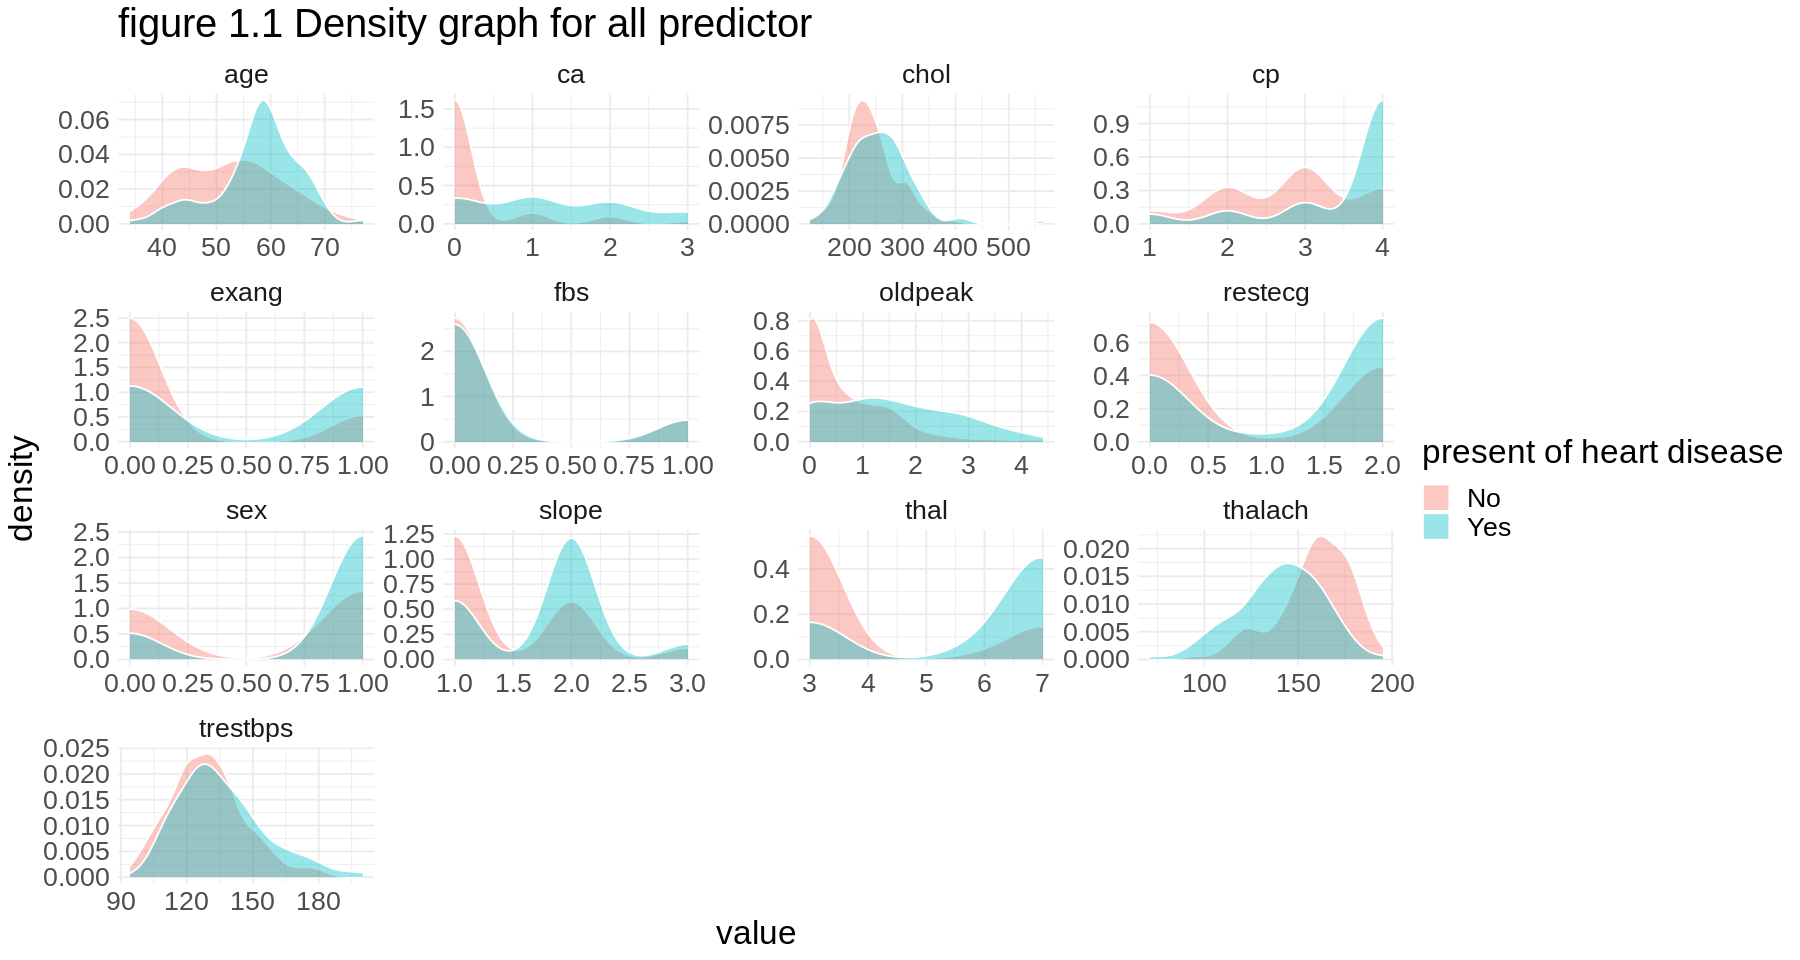

In [7]:
set.seed(2022)
cleveland_data_training_mutate= cleveland_training %>%
mutate(ca = as.numeric(ca), thal = as.numeric(thal))

options(repr.plot.height = 8, repr.plot.width = 15)
cleveland_data_training_mutate %>%
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))+
scale_fill_discrete(name='present of heart disease',labels=c("No", "Yes"))+
ggtitle("figure 1.1 Density graph for all predictor ")

!!! Add explanations on why we choose age and thalach as our predictors (state that we cannot perform classification on categorical variables, these two are the one that are numeric and most distinct from the graph above, etc.)


We first eliminated all the categorical variables, since we have only learnt about using numerical variables as predictors. If we directly convert the categorical variables into numerical, then the distance would have a negative effect on accuracy.  For example , cp(chest pain type) in our data set has three categories of chest pain and an asymptomatic type. However, the three chest pain category doesn’t necessarily have a rank in strength but rather being different in types of chest pain. Therefore, if we convert them to 1,2,3 respectively, then 1 would be further away from 3 compared with 2 to 3 , while the categories of 1 and 2 are equally different from category 3 in reality.   Thus, the act of converting categorical variables into numerical variables would significantly negatively affect the accuracy of the classifier. 

Thus, we deselect the following variables since they are categorical: ca ,cp , exang, fbs, restecg, sex, slope, thal. 

!!! after that why we choose age and thalach from (age, chol, oldpeak,thalach and trestbps)(mention strong chracteristic, unoverlaps area)



## Training Data Summary

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



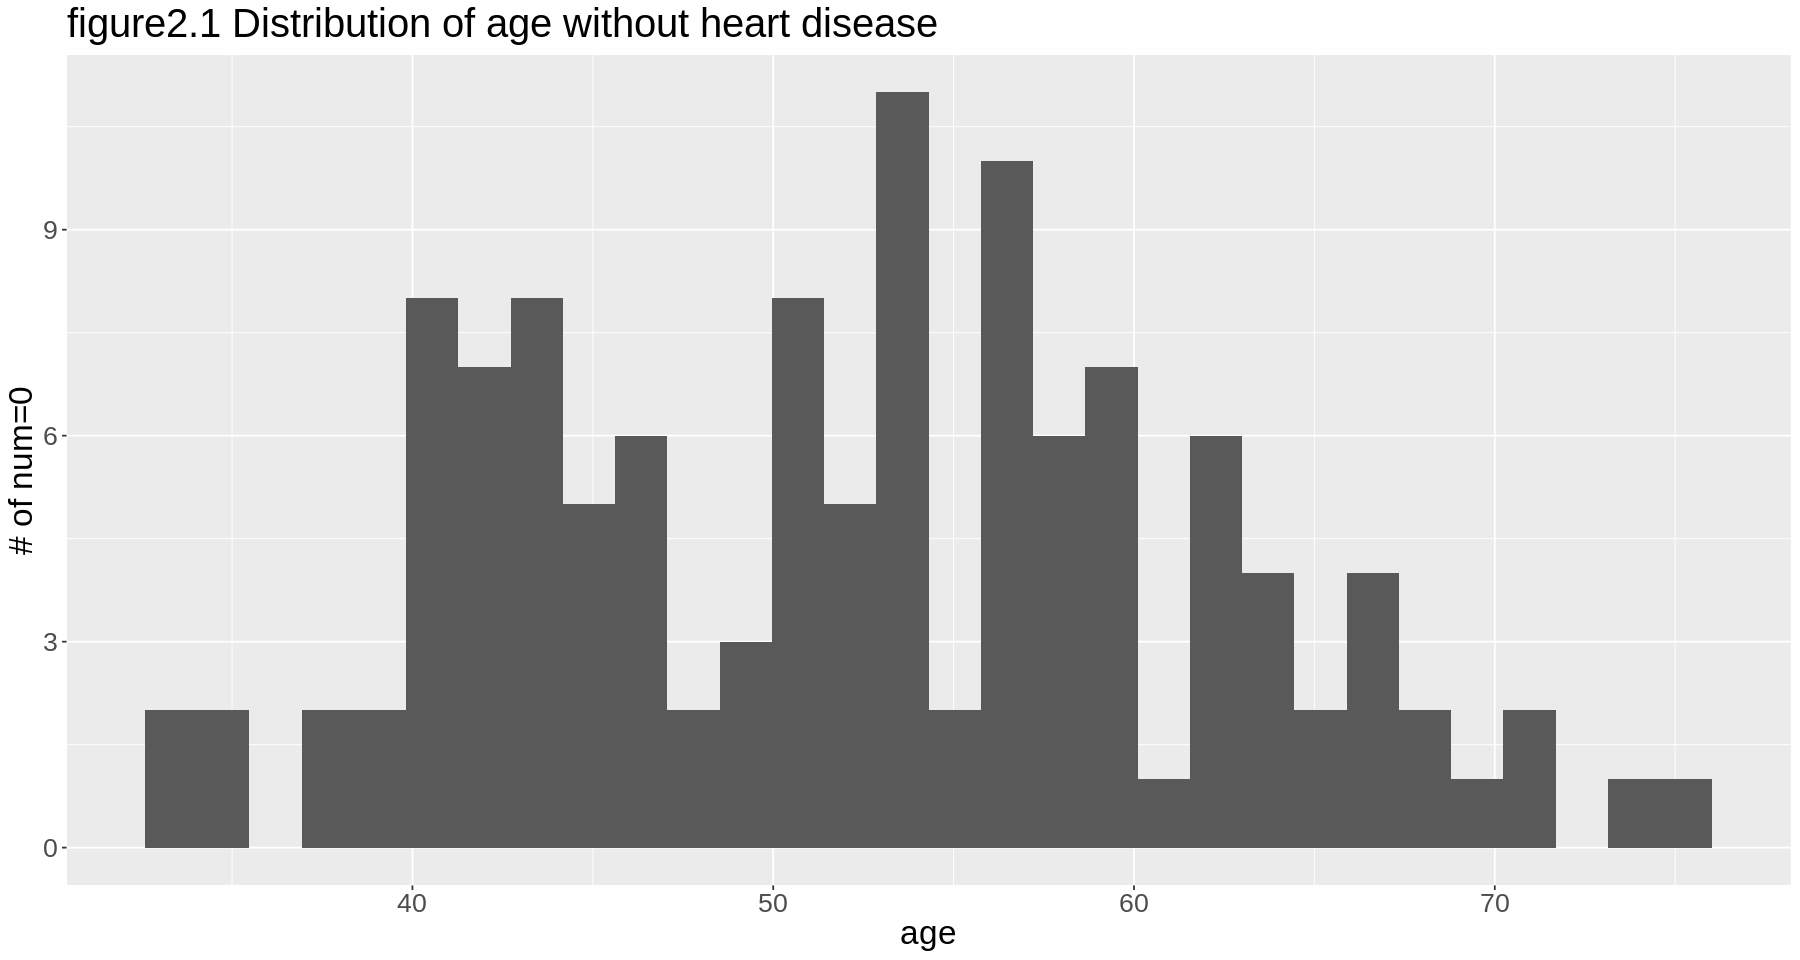

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



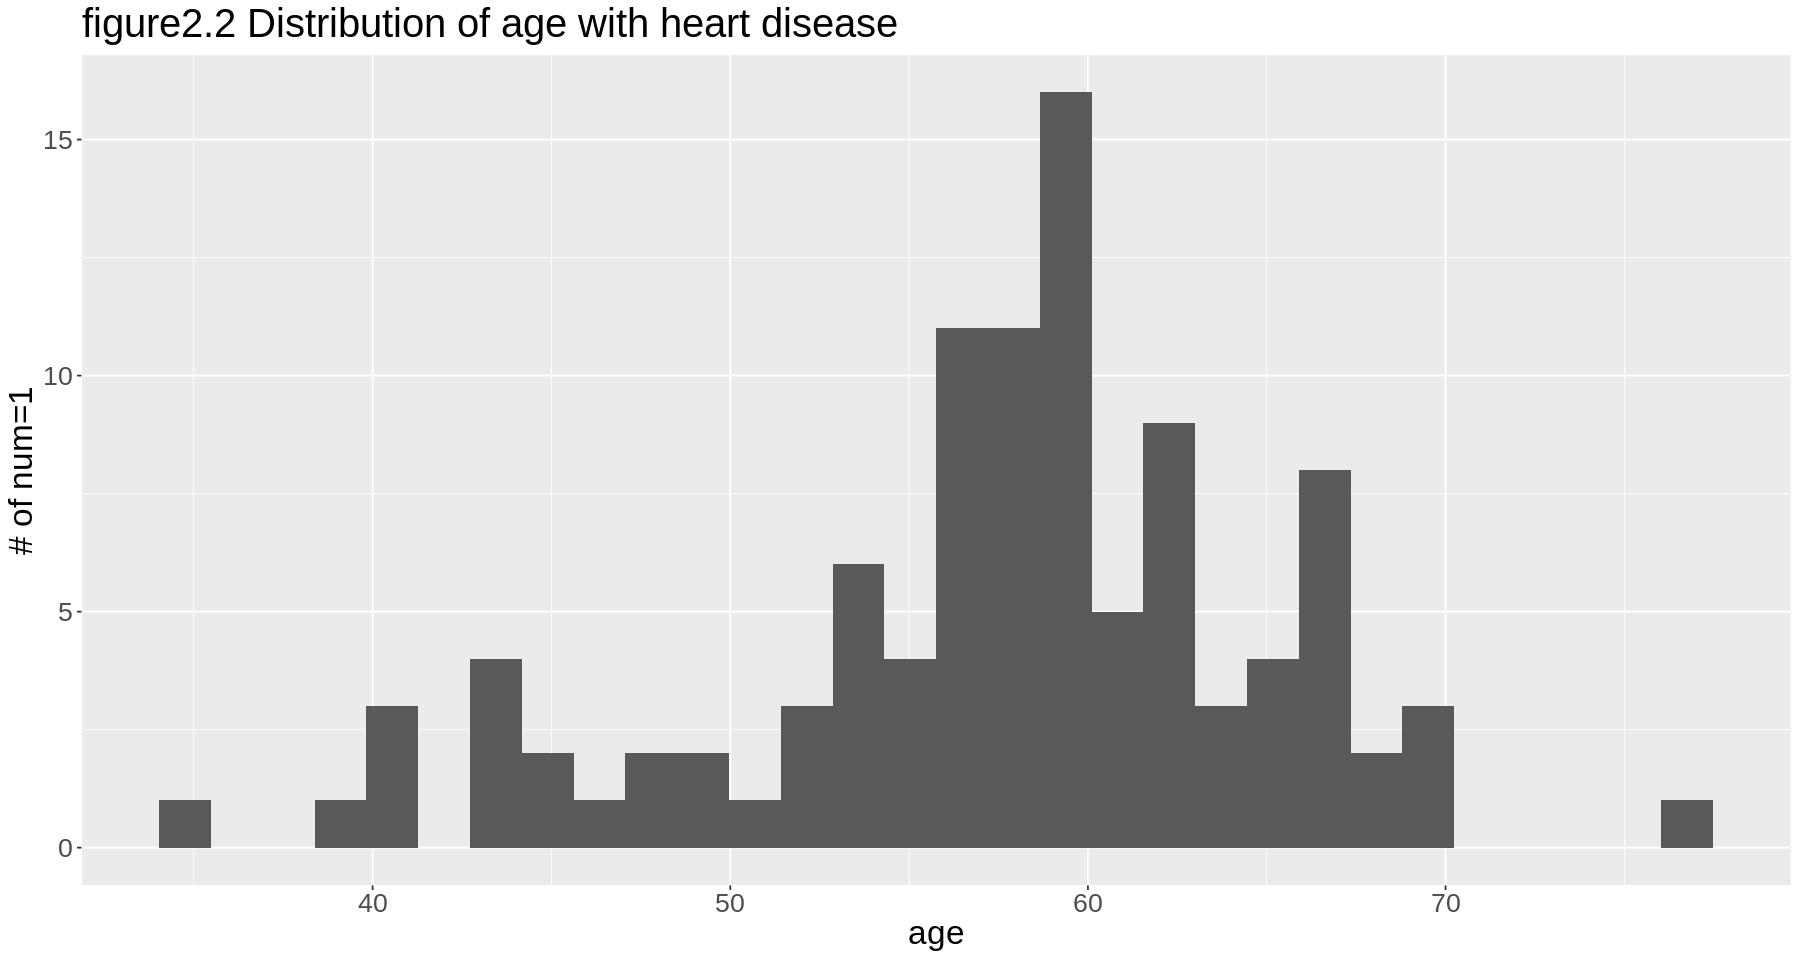

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



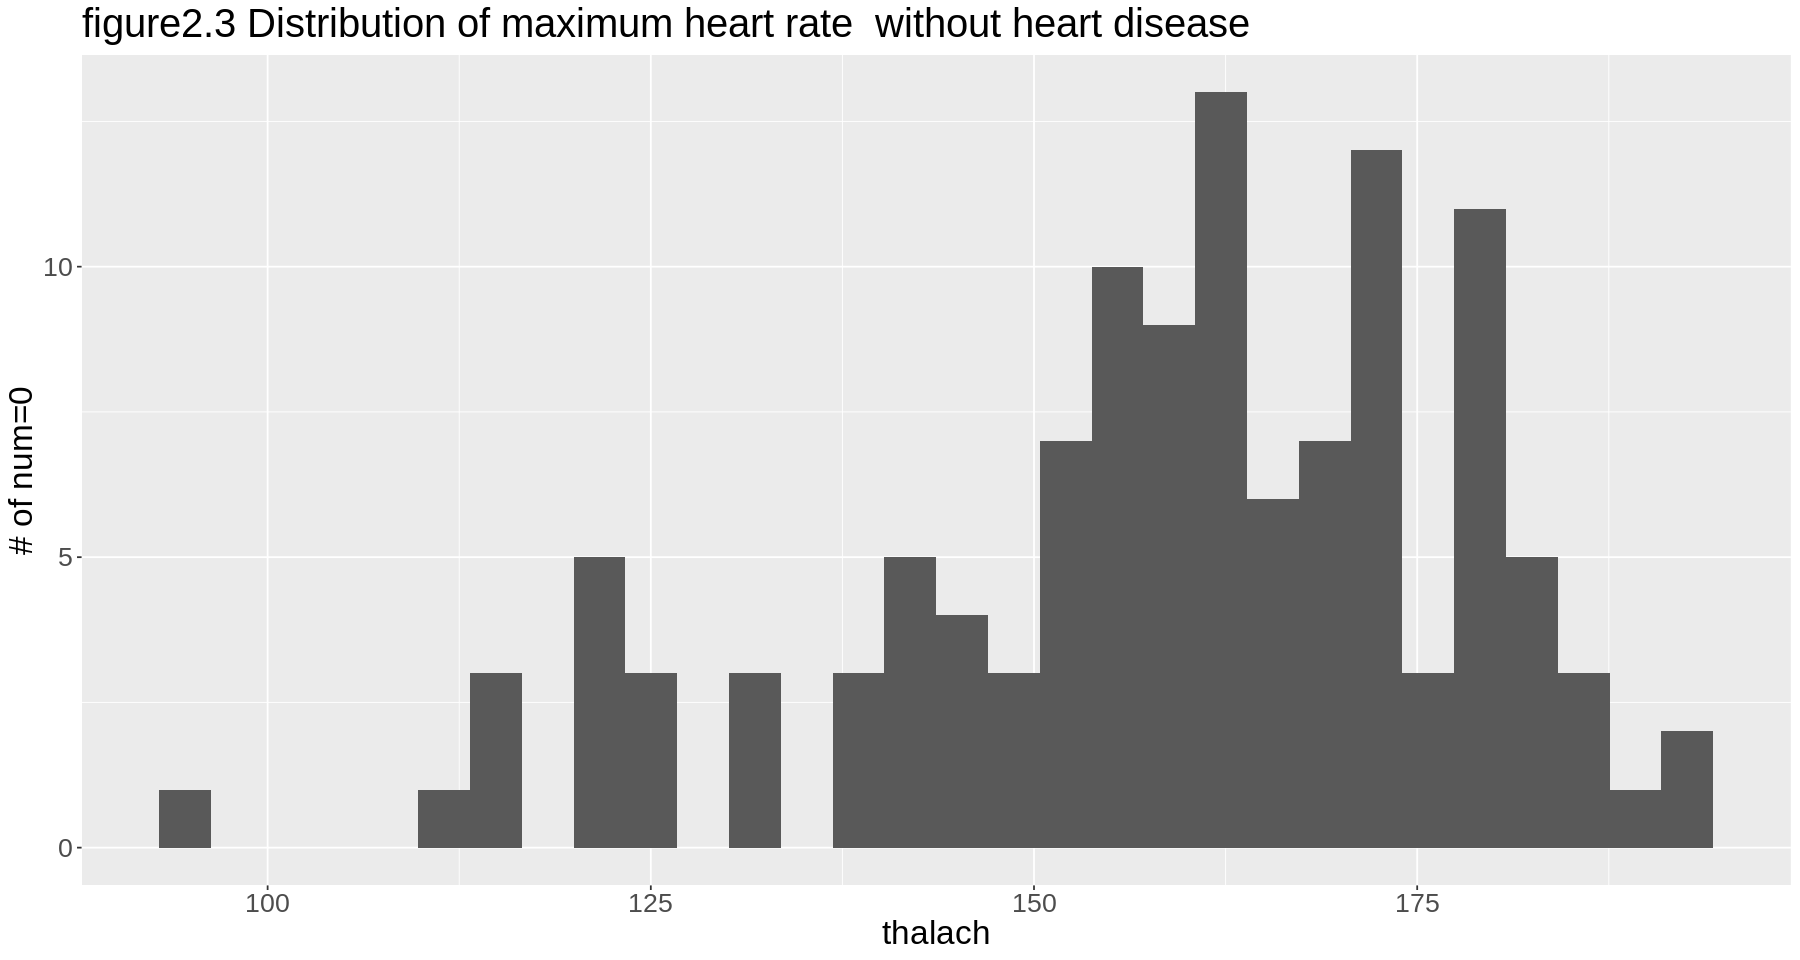

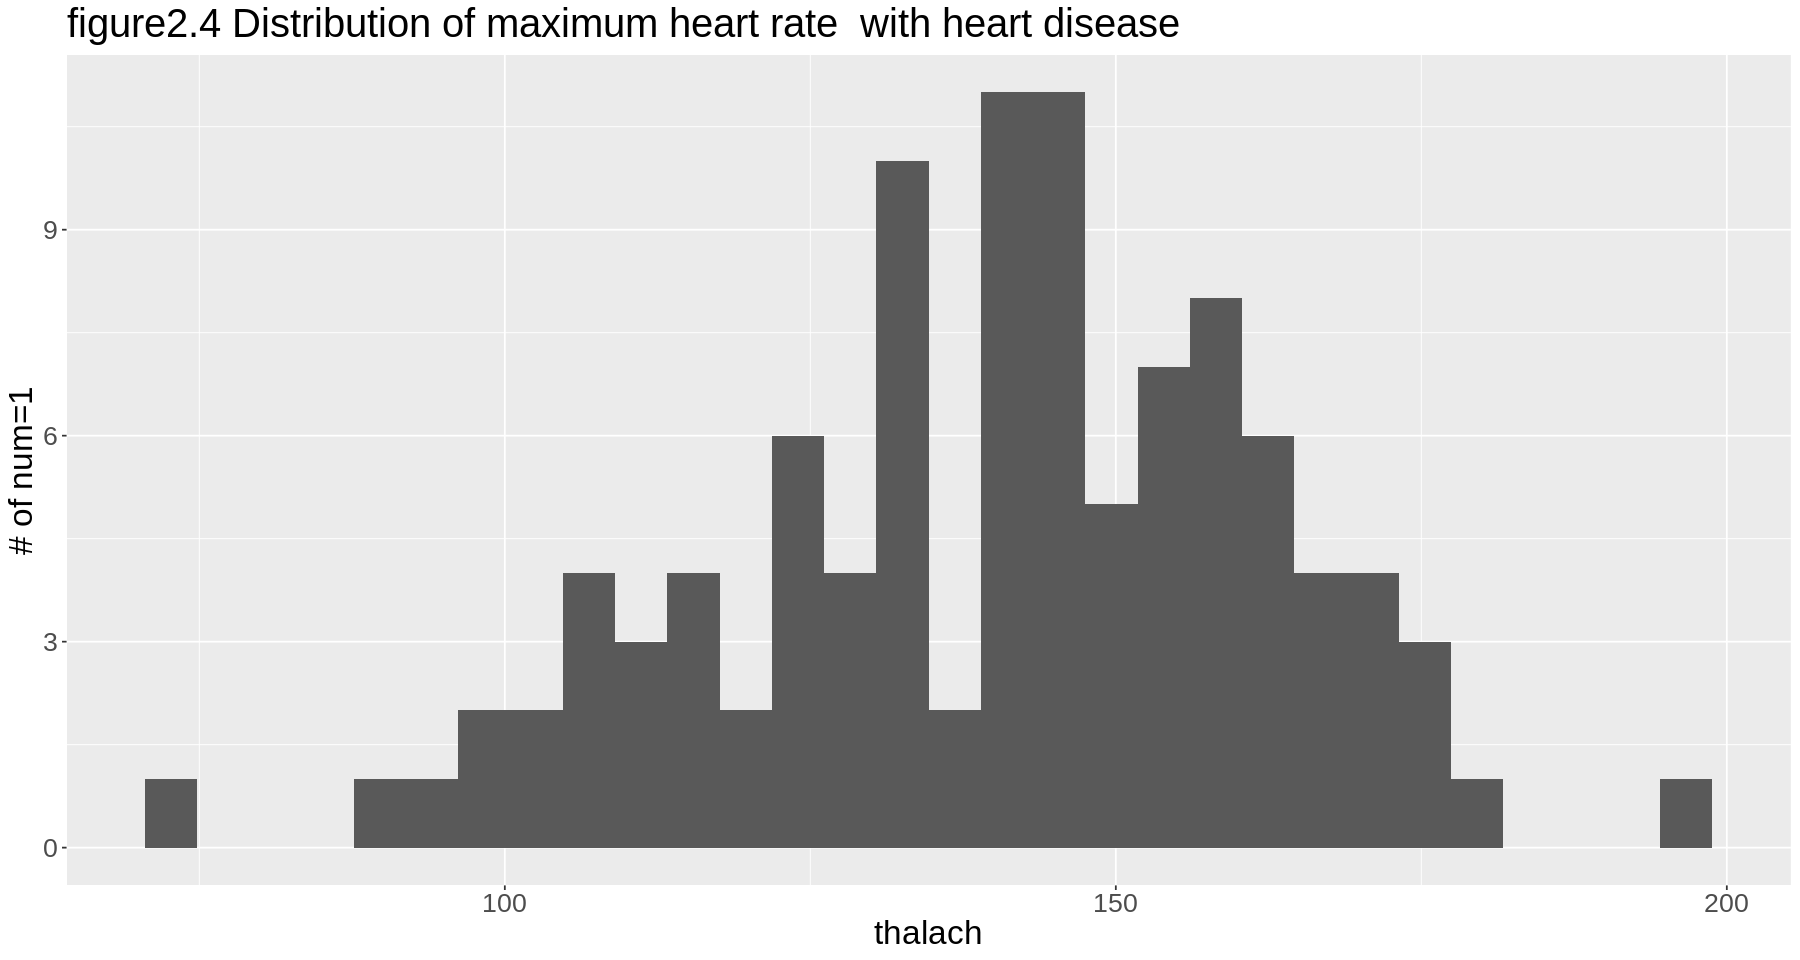

In [8]:
plot_age_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = age,)) + 
   geom_histogram() +
    labs(x= "age", y= "# of num=0")+
    theme(text = element_text(size=20))+
    ggtitle("figure2.1 Distribution of age without heart disease ")
plot_age_0

plot_age_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = age,)) + 
   geom_histogram() +
    labs(x= "age", y= "# of num=1")+
    theme(text = element_text(size=20))+
    ggtitle("figure2.2 Distribution of age with heart disease")
plot_age_1


plot_thalach_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = thalach,)) + 
   geom_histogram() +
    labs(x= "thalach", y= "# of num=0")+
    theme(text = element_text(size=20))+
    ggtitle("figure2.3 Distribution of maximum heart rate  without heart disease")
plot_thalach_0

plot_thalach_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = thalach,)) + 
   geom_histogram() +
    labs(x= "thalach", y= "# of num=1")+
    theme(text = element_text(size=20))+
    ggtitle("figure2.4 Distribution of maximum heart rate  with heart disease")
plot_thalach_1

!!! Add explanations on why we use histogram , like why???????

In [9]:
#summary and mean values
set.seed(2022)

#missing values are removed in the cleaning process (6 missing values in total)

# cleveland_training %>%
# group_by(num)%>%
# summarize(n=n())

# cleveland_training %>%
# summarize(n=n())

# cleveland_training %>%
# mutate (avg_age = mean(age),  
#        avg_thalach = mean(thalach))%>%
# select (avg_age ,avg_thalach)%>%
# slice (1)

# cleveland_training %>%
# filter(num == 0)%>%
# mutate (avg_age_nohd = mean(age),  
#        avg_thalach_nohd = mean(thalach))%>%
# select (avg_age_nohd ,avg_thalach_nohd)%>%
# slice (1)

# cleveland_training %>%
# filter(num == 1)%>%
# mutate (avg_age_hd = mean(age),  
#        avg_thalach_hd = mean(thalach))%>%
# select (avg_age_hd ,avg_thalach_hd)%>%
# slice (1)


# ↑where we get our value for the table (comment out for cleanliness)
sum_table <- data.frame(without_hd = 120, with_hd =103, n_of_row = 223,
                        avg_age = 54.81614, avg_age_nohd = 52.40833 ,avg_age_hd =57.62136, 
                        avg_thalach =150.1883, avg_thalach_nohd= 158.6333 ,  avg_thalach_hd= 140.3495)
sum_table

without_hd,with_hd,n_of_row,avg_age,avg_age_nohd,avg_age_hd,avg_thalach,avg_thalach_nohd,avg_thalach_hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120,103,223,54.81614,52.40833,57.62136,150.1883,158.6333,140.3495


Table2.1 Number of people and their averge age , max heart rate with heart disease and without heart disease and combained.

!!! explain the sinificant of these value

Below is an visualization of the relationship between patients' age and thalach, and whether they have heart disease or not.

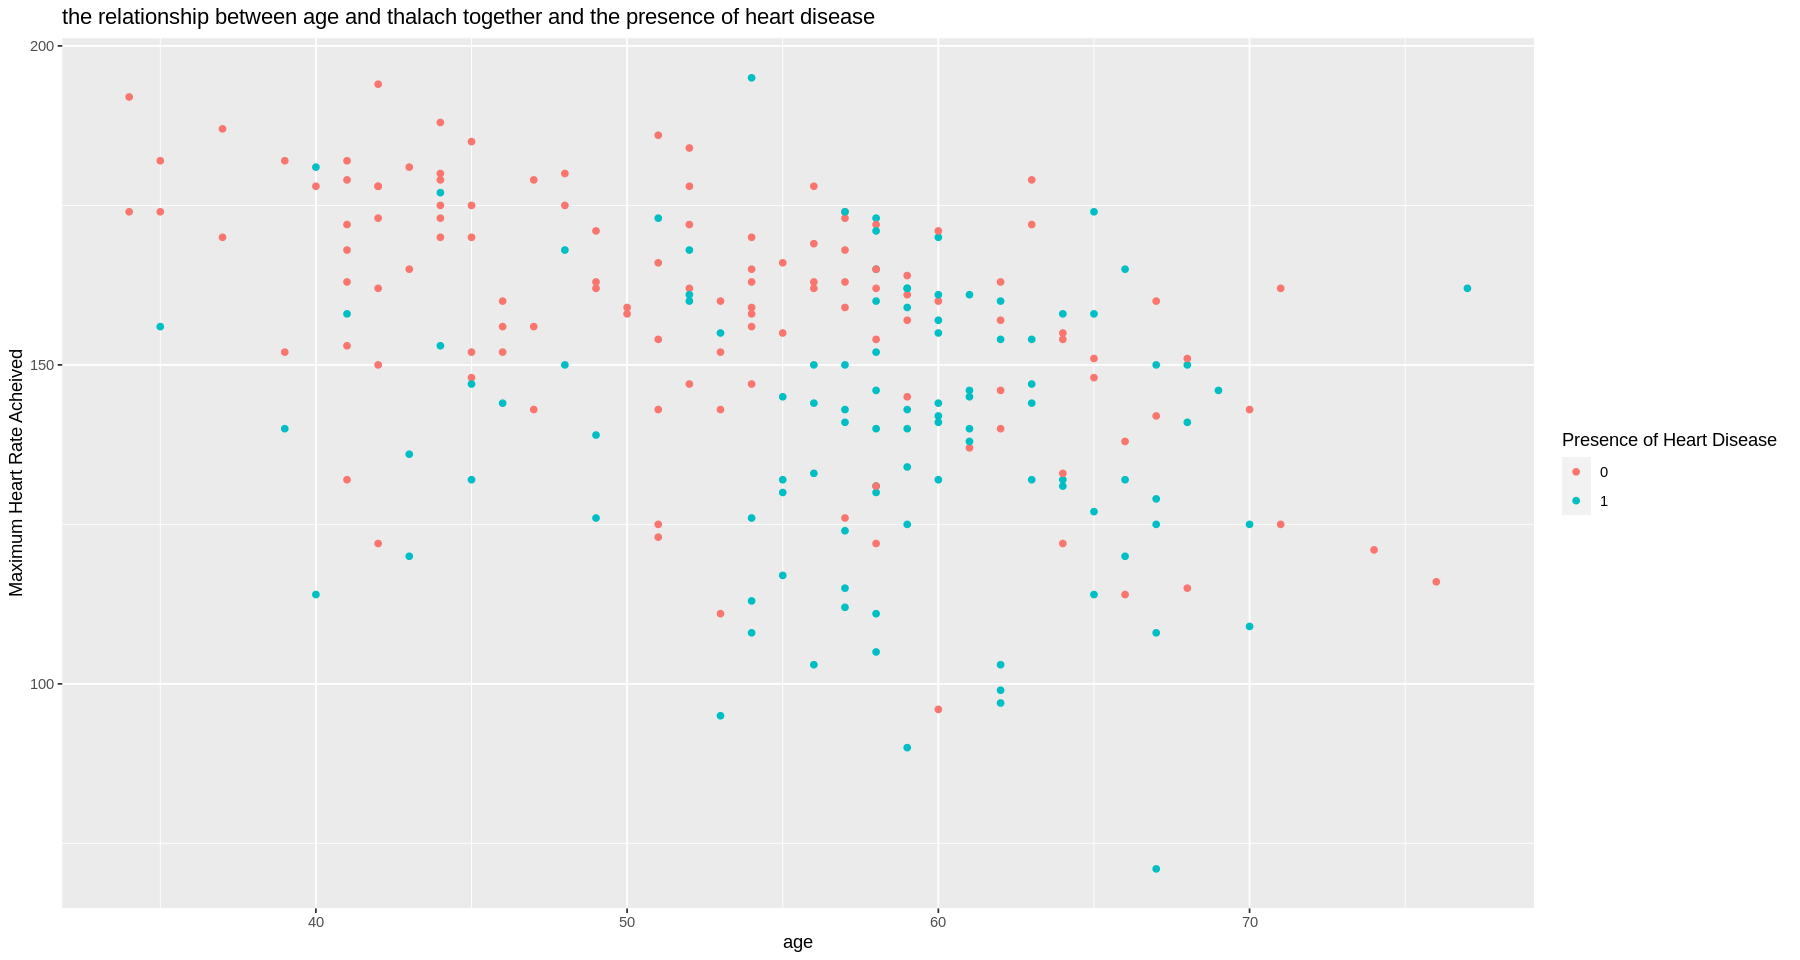

In [11]:
visuals <- cleveland_training %>% 
           ggplot(aes(x = age, y = thalach, color = num)) +
           geom_point() +
           labs(x = "age", y = "Maximum Heart Rate Acheived", color = "Presence of Heart Disease") +
           ggtitle("the relationship between age and thalach together and the presence of heart disease")
visuals

# Method 

We hypothesize that age and max heart rate are the most related to heart disease, so we will use the two columns “age" and “thalach”, as well as num (have(0) / don’t have heart disease(1)) in our data analysis.



We build ad train our classifier by performing the following steps:




1. We create the recipe and specified the variable to be predicted to be num and predictors to be age and max heart rate. We scaled and centered all the predictors for accurate results.
2.For stronger performance, we perform 10 v-fold on the training data.
3.We specify the knn model and set engine to kknn, mode to classification and use knn_tune to pick the best value for knn.
4.We put everything together by workflow. The recipe, model, and v-fold is put together, and we use collect_metrics to show metrics. After that, we filter only the accuracy metric to only show accuracy.
5.We plot the accuracy against the knn. Then, we could see which knn value has the highest accuracy, and pick our knn value accordingly.




In [ ]:
set.seed(2022)

vrecipe <- recipe(num~ age + thalach , data = cleveland_training)%>%
  step_scale(all_numeric()) %>%
    step_center(all_numeric())

vfold <- vfold_cv( cleveland_training, v = 10, strata = num)
knn_tune= nearest_neighbor(weight_func = "rectangular", neighbors = tune() )%>%
    set_engine("kknn")%>%
    set_mode("classification")


knn_results <- workflow() %>%
       add_recipe(vrecipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = vfold, grid = 10) %>%
       collect_metrics()

accuracies <- knn_results %>% 
        filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       ggtitle("figure3.1 Plot of accuracy estimate versus number of neighbors")+
       scale_x_continuous(breaks = c(0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15))+
       theme(plot.title = element_text(size=22))

cross_val_plot 


In [ ]:
#determine the best neighbor number
best_neightbors <- accuracies%>%
arrange(neighbors)%>%
select(mean, neighbors)%>%
arrange(desc(mean))%>%
slice(1)
best_neightbors

table3.1 Number of neighbors with the highest accuracy.<blockquote>To prevent confusion of whether to use 10 or 14 for our best number of neighbors , we use the arrange and slice function to directly select our K value that has the highest accuracy.<blockquote>

After training our classifier, we use it to predict the testing dataset by performing the following steps:





1. We perform the recipe and knn_model steps again, and put it in the workflow, assign it to an object called mnist_fit.
2. In order to show the accuracy of our classifier, we perform a prediction on our testing dataset by passing the mnist_fit and the testing dataset to the predict function. A testing column is bound to the data output.
3. we use the metric function to show the accuracy of our classifier. 


In [ ]:
set.seed(2022)

cleveland_recipe <- recipe(num ~age  + thalach , data = cleveland_training)%>%
  step_scale(all_predictors()) %>%
    step_center(all_predictors())


mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors =14) %>%
    set_engine("kknn") %>%
    set_mode("classification")

mnist_fit <- workflow() %>%
        add_recipe(cleveland_recipe)%>%
        add_model(mnist_spec) %>%
        fit(data = cleveland_training)

mnist_predictions <- predict (mnist_fit, cleveland_testing) %>%
    bind_cols(cleveland_testing)

mnist_metrics <- mnist_predictions %>%
    metrics(truth = num, estimate = .pred_class)%>%
filter(.metric == "accuracy")
mnist_metrics

table3.2 accuracy of our classifier is 71.6%

# Impact &Discussion

!!! Add explanations , ALOT OF EXPLAINATION 😭 

check list 
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

# Citation

#### Reference artical

Piga, A., 2008. High nontransferrin bound iron levels and heart disease in thalassemia major.
[online] Wiley online library. Available at: https://onlinelibrary.wiley.com/doi/abs/10.1002/ajh.21317 [Accessed 5 April 2022].

Chen, A., 2022. HDPS: Heart disease prediction system.
[online] Ieeexplore.ieee.org. Available at: https://ieeexplore.ieee.org/abstract/document/6164626 [Accessed 5 April 2022].


#### Data source
W. Aha, D., 2022. UCI Machine Learning Repository: Heart Disease Data Set.
[online] Archive.ics.uci.edu. Available at: https://archive.ics.uci.edu/ml/datasets/Heart+Disease [Accessed 6 April 2022].
